<a href="https://colab.research.google.com/github/PamelaVQ/Base-ML/blob/master/Pytorch_Basics/convolutional_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Create a simple autoencoder using pytorch

In [214]:
import torch
from torchvision.datasets import FashionMNIST, MNIST
from torchvision.utils import make_grid
from torch import nn
from torchvision import transforms
from torch.utils.data import dataloader
from torch.autograd import Variable

In [248]:
transforms_list = [transforms.functional.adjust_brightness(img, brightness_factor=2),transforms.functional.hflip(img)]
dataset = MNIST(root='.', download=True, transform=transforms.Compose([transforms.ToTensor(), 
                                                                              transforms.Normalize([0.5], [0.5]), 
                                                                       ]))

In [249]:
# create a dataloader
batch_size = 128
mnist_data = dataloader.DataLoader(dataset, batch_size=batch_size, shuffle=True)
print(dataset.data.shape)


torch.Size([60000, 28, 28])


In [250]:
# create a convolutional autoencoder
class Encoder(nn.Module):
  def __init__(self, c, embedding_size): # [b, 1, 28, 28]
    super(Encoder, self).__init__()
    self.conv2d1 = nn.Conv2d(c, 10, 5, stride=2, padding=1)
    self.conv2d2 = nn.Conv2d(10, 20, 3, stride=2, padding=1)
    # self.maxpool = nn.MaxPool2d(3)
    self.conv2d3 = nn.Conv2d(20, 40, 5, stride=3, padding=1)
    self.fully = nn.Linear(160, embedding_size) 

  def forward(self, x):
    x = torch.relu(self.conv2d1(x))
    x = torch.relu(self.conv2d2(x))
    # x = self.maxpool(x)
    x = torch.relu(self.conv2d3(x))
    x = x.view(x.data.shape[0], 160)
    x = self.fully(x)
    return x

class Decoder(nn.Module):
  def __init__(self, c, input_size):
    super(Decoder, self).__init__()
    self.fully = nn.Linear(input_size, 160) 
    self.conv2d1 = nn.ConvTranspose2d(40, 20, 5, stride=4, padding=1)
    self.conv2d2 = nn.ConvTranspose2d(20, 10, 3, stride=2, padding=1)
    self.conv2d3 = nn.ConvTranspose2d(10, c, 6, stride=2, padding=1)

  def forward(self, x):
    x = self.fully(x)
    x = x.view(x.data.shape[0], 40, 2, 2)
    x = torch.relu(self.conv2d1(x))
    x = torch.relu(self.conv2d2(x))
    x = torch.relu(self.conv2d3(x))
    return x


In [251]:
channels = 1
encoder = Encoder(channels, embedding_size=40)
decoder = Decoder(channels, input_size=40)

autoencoder = nn.Sequential(encoder, decoder)

In [252]:
x = Variable(torch.ones(batch_size, channels, 28, 28))
e = encoder(x)
d = decoder(e)

print('Input\t ', list(x.data.shape))
print('Embedding', list(e.data.shape))
print('Output\t ', list(d.data.shape))

Input	  [128, 1, 28, 28]
Embedding [128, 40]
Output	  [128, 1, 28, 28]


In [253]:
model = autoencoder.cuda()
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(model.parameters())
model.train()

Sequential(
  (0): Encoder(
    (conv2d1): Conv2d(1, 10, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (conv2d2): Conv2d(10, 20, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2d3): Conv2d(20, 40, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (fully): Linear(in_features=160, out_features=40, bias=True)
  )
  (1): Decoder(
    (fully): Linear(in_features=40, out_features=160, bias=True)
    (conv2d1): ConvTranspose2d(40, 20, kernel_size=(5, 5), stride=(4, 4), padding=(1, 1))
    (conv2d2): ConvTranspose2d(20, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2d3): ConvTranspose2d(10, 1, kernel_size=(6, 6), stride=(2, 2), padding=(1, 1))
  )
)

In [254]:
# Create transforms
def img_transform(img):
  transforms_list = [transforms.functional.adjust_brightness(img, brightness_factor=2)]
  # transforms.RandomApply(transforms_list, p=0.5)(img)
  img =  transforms.Compose([transforms.ToPILImage(), transforms.RandomApply(transforms_list, p=0.5), 
                             transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])(img)
  # print(type(img))
  return img

def img_normalize(img):
  img =  transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
  return img

In [259]:
# print(mnist_data.dataset.data[0].shape)
num_epochs = 100
epoch_loss = []
for epoch in range(num_epochs):
  batch_loss = []
  for batch_num, (data, _) in enumerate(mnist_data): # data = [128, 1, 28, 28]
    # print(data.shape)
    optim.zero_grad()
    # data = data.view(data.shape[0], -1) # data = [128, 784]
    # print(data.shape)
    # input = img_transform(data)
    # data = img_normalize(data)
    data = Variable(data).cuda()
    # print(data.shape)
    
    # print(input.shape)
    output = model(data)
    loss = loss_fn(output, data)
    loss.backward()
    optim.step()
    batch_loss.append(loss)
  epoch_loss.append(sum(batch_loss)/len(batch_loss))
  print(f'Epoch {epoch}:\tloss {epoch_loss[-1]:.4f}')

Epoch 0:	loss 0.8408
Epoch 1:	loss 0.8406
Epoch 2:	loss 0.8406
Epoch 3:	loss 0.8405
Epoch 4:	loss 0.8405
Epoch 5:	loss 0.8404
Epoch 6:	loss 0.8404
Epoch 7:	loss 0.8403
Epoch 8:	loss 0.8403
Epoch 9:	loss 0.8402
Epoch 10:	loss 0.8402
Epoch 11:	loss 0.8402
Epoch 12:	loss 0.8401
Epoch 13:	loss 0.8401
Epoch 14:	loss 0.8401
Epoch 15:	loss 0.8400
Epoch 16:	loss 0.8400
Epoch 17:	loss 0.8400
Epoch 18:	loss 0.8400
Epoch 19:	loss 0.8399
Epoch 20:	loss 0.8399
Epoch 21:	loss 0.8399
Epoch 22:	loss 0.8399
Epoch 23:	loss 0.8398
Epoch 24:	loss 0.8398
Epoch 25:	loss 0.8398
Epoch 26:	loss 0.8398
Epoch 27:	loss 0.8397
Epoch 28:	loss 0.8397
Epoch 29:	loss 0.8397
Epoch 30:	loss 0.8397
Epoch 31:	loss 0.8397
Epoch 32:	loss 0.8397
Epoch 33:	loss 0.8397
Epoch 34:	loss 0.8396
Epoch 35:	loss 0.8396
Epoch 36:	loss 0.8396
Epoch 37:	loss 0.8396
Epoch 38:	loss 0.8396
Epoch 39:	loss 0.8396
Epoch 40:	loss 0.8396
Epoch 41:	loss 0.8395
Epoch 42:	loss 0.8395
Epoch 43:	loss 0.8395
Epoch 44:	loss 0.8395
Epoch 45:	loss 0.839

In [260]:
def to_img(x):
    x = 0.5 * x + 0.5
    x = x.clamp(0, 1)
    x = x.view(x.shape[0], 1, 28, 28)
    return x

In [261]:
import matplotlib.pyplot as plt
import numpy as np
def show(img):
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

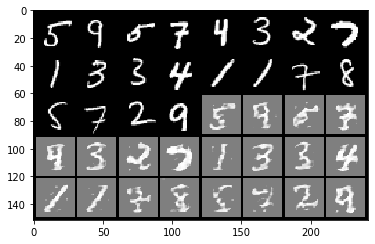

In [262]:
# print output
print_data = dataloader.DataLoader(dataset, batch_size=20, shuffle=True)
from PIL import Image
for batch_num, (data, _) in enumerate(print_data):
    img1 = to_img(data)
    data = Variable(img1).cuda()
    output = model(data)
    output = output.cpu()
    img = to_img(output)
    show(make_grid(torch.cat([img1, img])))
    break